# FSRS4Anki Optimizer mini-batch punish pls

[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-spaced-repetition/fsrs4anki/blob/main/archive/experiment/mini-batch_punish_pls.ipynb)

↑ Click the above button to open the optimizer on Google Colab.

> If you can't see the button and are located in the Chinese Mainland, please use a proxy or VPN.

Upload your **Anki Deck Package (.apkg)** file or **Anki Collection Package (.colpkg)** file on the `Left sidebar -> Files`, drag and drop your file in the current directory (not the `sample_data` directory). 

No need to include media. Need to include scheduling information. 

> If you use the latest version of Anki, please check the box `Support older Anki versions (slower/larger files)` when you export.

You can export it via `File -> Export...` or `Ctrl + E` in the main window of Anki.

Then replace the `filename` with yours in the next code cell. And set the `timezone` and `next_day_starts_at` which can be found in your preferences of Anki.

After that, just run all (`Runtime -> Run all` or `Ctrl + F9`) and wait for minutes. You can see the optimal parameters in section **2.3 Result**. Copy them, replace the parameters in `fsrs4anki_scheduler.js`, and paste them into the custom scheduling of your deck options (require Anki version >= 2.1.55).

**NOTE**: The default output is generated from my review logs. If you find the output is the same as mine, maybe your notebook hasn't run there.

**Contribute to SRS Research**: If you want to share your data with me, please fill this form: https://forms.gle/KaojsBbhMCytaA7h8

In [1]:
# Here are some settings that you need to replace before running this optimizer.

filename = "../collection-2022-09-18@13-21-58.colpkg"
# If you upload deck file, replace it with your deck filename. E.g., ALL__Learning.apkg
# If you upload collection file, replace it with your colpgk filename. E.g., collection-2022-09-18@13-21-58.colpkg

# Replace it with your timezone. I'm in China, so I use Asia/Shanghai.
# You can find your timezone here: https://gist.github.com/heyalexej/8bf688fd67d7199be4a1682b3eec7568
timezone = 'Asia/Shanghai'

# Replace it with your Anki's setting in Preferences -> Scheduling.
next_day_starts_at = 4

# Replace it if you don't want the optimizer to use the review logs before a specific date.
revlog_start_date = "2006-10-05"

## 1 Build dataset

### 1.1 Extract Anki collection & deck file

In [2]:
import zipfile
import sqlite3
import time
from tqdm import notebook
import pandas as pd
import numpy as np
import os
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
import math
import torch
from torch import nn
import warnings

notebook.tqdm.pandas()
warnings.filterwarnings("ignore", category=UserWarning)


# Extract the collection file or deck file to get the .anki21 database.
with zipfile.ZipFile(f'./{filename}', 'r') as zip_ref:
    zip_ref.extractall('./')
    print("Extract successfully!")


Extract successfully!


### 1.2 Create time-series feature & analysis

The following code cell will extract the review logs from your Anki collection and preprocess them to a trainset which is saved in [./revlog_history.tsv](./revlog_history.tsv).

The time-series features are important in optimizing the model's parameters. For more detail, please see my paper: https://www.maimemo.com/paper/

Then it will generate a concise analysis for your review logs. 

- The `r_history` is the history of ratings on each review. `3,3,3,1` means that you press `Good, Good, Good, Again`. It only contains the first rating for each card on the review date, i.e., when you press `Again` in review and  `Good` in relearning steps 10min later, only `Again` will be recorded.
- The `avg_interval` is the actual average interval after you rate your cards as the `r_history`. It could be longer than the interval given by Anki's built-in scheduler because you reviewed some overdue cards.
- The `avg_retention` is the average retention after you press as the `r_history`. `Again` counts as failed recall, and `Hard, Good and Easy` count as successful recall. Retention is the percentage of your successful recall.
- The `stability` is the estimated memory state variable, which is an approximate interval that leads to 90% retention.
- The `factor` is `stability / previous stability`.
- The `group_cnt` is the number of review logs that have the same `r_history`.

In [3]:
if os.path.isfile("collection.anki21b"):
    os.remove("collection.anki21b")
    raise Exception(
        "Please export the file with `support older Anki versions` if you use the latest version of Anki.")
elif os.path.isfile("collection.anki21"):
    con = sqlite3.connect("collection.anki21")
elif os.path.isfile("collection.anki2"):
    con = sqlite3.connect("collection.anki2")
else:
    raise Exception("Collection not exist!")
cur = con.cursor()
res = cur.execute("SELECT * FROM revlog")
revlog = res.fetchall()

df = pd.DataFrame(revlog)
df.columns = ['id', 'cid', 'usn', 'r', 'ivl',
              'last_lvl', 'factor', 'time', 'type']
df = df[(df['cid'] <= time.time() * 1000) &
        (df['id'] <= time.time() * 1000) &
        (df['r'] > 0)].copy()
df['create_date'] = pd.to_datetime(df['cid'] // 1000, unit='s')
df['create_date'] = df['create_date'].dt.tz_localize(
    'UTC').dt.tz_convert(timezone)
df['review_date'] = pd.to_datetime(df['id'] // 1000, unit='s')
df['review_date'] = df['review_date'].dt.tz_localize(
    'UTC').dt.tz_convert(timezone)
df.drop(df[df['review_date'].dt.year < 2006].index, inplace=True)
df.sort_values(by=['cid', 'id'], inplace=True, ignore_index=True)
type_sequence = np.array(df['type'])
time_sequence = np.array(df['time'])
df.to_csv("revlog.csv", index=False)
print("revlog.csv saved.")
df = df[(df['type'] != 3) | (df['factor'] != 0)].copy()
df['real_days'] = df['review_date'] - timedelta(hours=next_day_starts_at)
df['real_days'] = pd.DatetimeIndex(df['real_days'].dt.floor('D', ambiguous='infer', nonexistent='shift_forward')).to_julian_date()
df.drop_duplicates(['cid', 'real_days'], keep='first', inplace=True)
df['delta_t'] = df.real_days.diff()
df.dropna(inplace=True)
df['delta_t'] = df['delta_t'].astype(dtype=int)

df['i'] = df.groupby('cid').cumcount() + 1
df.loc[df['i'] == 1, 'delta_t'] = 0


df = df.groupby('cid').filter(lambda group: group['type'].iloc[0] == 0)
df['prev_type'] = df.groupby('cid')['type'].shift(1).fillna(0).astype(int)
df['helper'] = (df['type'] == 0) & ((df['prev_type'] == 1) | (df['prev_type'] == 2)) & (df['i'] > 1)
df['helper'] = df['helper'].astype(int)
df['helper'] = df.groupby('cid')['helper'].cumsum()
df = df[df['helper'] == 0]
del df['prev_type']
del df['helper']
from itertools import accumulate

def cum_concat(x):
    return list(accumulate(x))

t_history = df.groupby('cid', group_keys=False)['delta_t'].apply(lambda x: cum_concat([[i] for i in x]))
df['t_history']=[','.join(map(str, item[:-1])) for sublist in t_history for item in sublist]
r_history = df.groupby('cid', group_keys=False)['r'].apply(lambda x: cum_concat([[i] for i in x]))
df['r_history']=[','.join(map(str, item[:-1])) for sublist in r_history for item in sublist]
df = df[df['id'] >= time.mktime(datetime.strptime(revlog_start_date, "%Y-%m-%d").timetuple()) * 1000]
df.to_csv('revlog_history.tsv', sep="\t", index=False)
print("Trainset saved.")

df['y'] = df['r'].map(lambda x: {1: 0, 2: 1, 3: 1, 4: 1}[x])
df['retention'] = df.groupby(by=['r_history', 'delta_t'], group_keys=False)['y'].transform('mean')
df['total_cnt'] = df.groupby(by=['r_history', 'delta_t'], group_keys=False)['id'].transform('count')
print("Retention calculated.")
df = df.drop(columns=['id', 'cid', 'usn', 'ivl', 'last_lvl', 'factor', 'time', 'type', 'create_date', 'review_date', 'real_days', 'r', 't_history', 'y'])
df.drop_duplicates(inplace=True)
df['retention'] = df['retention'].map(lambda x: max(min(0.99, x), 0.01))

def cal_stability(group: pd.DataFrame) -> pd.DataFrame:
    group_cnt = sum(group['total_cnt'])
    if group_cnt < 10:
        return pd.DataFrame()
    group['group_cnt'] = group_cnt
    if group['i'].values[0] > 1:
        r_ivl_cnt = sum(group['delta_t'] * group['retention'].map(np.log) * pow(group['total_cnt'], 2))
        ivl_ivl_cnt = sum(group['delta_t'].map(lambda x: x ** 2) * pow(group['total_cnt'], 2))
        group['stability'] = round(np.log(0.9) / (r_ivl_cnt / ivl_ivl_cnt), 1)
    else:
        group['stability'] = 0.0
    group['avg_retention'] = round(sum(group['retention'] * pow(group['total_cnt'], 2)) / sum(pow(group['total_cnt'], 2)), 3)
    group['avg_interval'] = round(sum(group['delta_t'] * pow(group['total_cnt'], 2)) / sum(pow(group['total_cnt'], 2)), 1)
    del group['total_cnt']
    del group['retention']
    del group['delta_t']
    return group

df = df.groupby(by=['r_history'], group_keys=False).progress_apply(cal_stability)
print("Stability calculated.")
df.reset_index(drop = True, inplace = True)
df.drop_duplicates(inplace=True)
df.sort_values(by=['r_history'], inplace=True, ignore_index=True)

if df.shape[0] > 0:
    for idx in notebook.tqdm(df.index):
        item = df.loc[idx]
        index = df[(df['i'] == item['i'] + 1) & (df['r_history'].str.startswith(item['r_history']))].index
        df.loc[index, 'last_stability'] = item['stability']
    df['factor'] = round(df['stability'] / df['last_stability'], 2)
    df = df[(df['i'] >= 2) & (df['group_cnt'] >= 100)]
    df['last_recall'] = df['r_history'].map(lambda x: x[-1])
    df = df[df.groupby(['i', 'r_history'], group_keys=False)['group_cnt'].transform(max) == df['group_cnt']]
    df.to_csv('./stability_for_analysis.tsv', sep='\t', index=None)
    print("1:again, 2:hard, 3:good, 4:easy\n")
    print(df[df['r_history'].str.contains(r'^[1-4][^124]*$', regex=True)][['r_history', 'avg_interval', 'avg_retention', 'stability', 'factor', 'group_cnt']].to_string(index=False))
    print("Analysis saved!")

revlog.csv saved.
Trainset saved.
Retention calculated.


  0%|          | 0/64224 [00:00<?, ?it/s]

Stability calculated.


  0%|          | 0/1196 [00:00<?, ?it/s]

1:again, 2:hard, 3:good, 4:easy

      r_history  avg_interval  avg_retention  stability  factor  group_cnt
              1           1.7          0.765        1.0     inf       7997
            1,3           3.9          0.877        4.2    4.20       4174
          1,3,3           8.5          0.882        9.1    2.17       2711
        1,3,3,3          17.8          0.860       13.8    1.52       1619
      1,3,3,3,3          36.4          0.833       22.3    1.62        845
    1,3,3,3,3,3          74.7          0.861       36.4    1.63        402
  1,3,3,3,3,3,3         118.2          0.895       38.5    1.06        182
              2           1.0          0.901        1.1     inf        240
            2,3           3.5          0.946        8.3    7.55        201
          2,3,3          11.1          0.890        7.1    0.86        160
              3           1.5          0.962        5.4     inf       9134
            3,3           3.9          0.966       15.2    2.81    

## 2 Optimize parameter

### 2.1 Define the model

FSRS is a time-series model for predicting memory states.

In [4]:
init_w = [1, 1, 5, 0.5, 0.5, 0.2, 1.4, 0.2, 0.8, 2, 0.2, 0.2, 1]
'''
w[0]: initial_stability_for_again_answer
w[1]: initial_stability_step_per_rating
w[2]: initial_difficulty_for_good_answer
w[3]: initial_difficulty_step_per_rating
w[4]: next_difficulty_step_per_rating
w[5]: next_difficulty_reversion_to_mean_speed (used to avoid ease hell)
w[6]: next_stability_factor_after_success
w[7]: next_stability_stabilization_decay_after_success
w[8]: next_stability_retrievability_gain_after_success
w[9]: next_stability_factor_after_failure
w[10]: next_stability_difficulty_decay_after_success
w[11]: next_stability_stability_gain_after_failure
w[12]: next_stability_retrievability_gain_after_failure
For more details about the parameters, please see: 
https://github.com/open-spaced-repetition/fsrs4anki/wiki/Free-Spaced-Repetition-Scheduler
'''


class FSRS(nn.Module):
    def __init__(self, w):
        super(FSRS, self).__init__()
        self.w = nn.Parameter(torch.tensor(w))

    def stability_after_success(self, state, new_d, r):
        new_s = state[:,0] * (1 + torch.exp(self.w[6]) *
                        (11 - new_d) *
                        torch.pow(state[:,0], -self.w[7]) *
                        (torch.exp((1 - r) * self.w[8]) - 1))
        return new_s
    
    def stability_after_failure(self, state, new_d, r):
        new_s = self.w[9] * torch.pow(new_d, -self.w[10]) * torch.pow(
            state[:,0], self.w[11]) * torch.exp((1 - r) * self.w[12])
        return new_s

    def step(self, X, state):
        '''
        :param X: shape[batch_size, 2], X[:,0] is elapsed time, X[:,1] is rating
        :param state: shape[batch_size, 2], state[:,0] is stability, state[:,1] is difficulty
        :return state:
        '''
        if torch.equal(state, torch.zeros_like(state)):
            # first learn, init memory states
            new_s = self.w[0] + self.w[1] * (X[:,1] - 1)
            new_d = self.w[2] - self.w[3] * (X[:,1] - 3)
            new_d = new_d.clamp(1, 10)
        else:
            r = torch.exp(np.log(0.9) * X[:,0] / state[:,0])
            new_d = state[:,1] - self.w[4] * (X[:,1] - 3)
            new_d = self.mean_reversion(self.w[2], new_d)
            new_d = new_d.clamp(1, 10)
            condition = X[:,1] > 1
            new_s = torch.where(condition, self.stability_after_success(state, new_d, r), self.stability_after_failure(state, new_d, r))
        new_s = new_s.clamp(0.1, 36500)
        return torch.stack([new_s, new_d], dim=1)

    def forward(self, inputs, state=None):
        '''
        :param inputs: shape[seq_len, batch_size, 2]
        '''
        if state is None:
            state = torch.zeros((inputs.shape[1], 2))
        else:
            state, = state
        outputs = []
        for X in inputs:
            state = self.step(X, state)
            outputs.append(state)
        return torch.stack(outputs), state

    def mean_reversion(self, init, current):
        return self.w[5] * init + (1-self.w[5]) * current


class WeightClipper(object):
    def __init__(self, frequency=1):
        self.frequency = frequency

    def __call__(self, module):
        if hasattr(module, 'w'):
            w = module.w.data
            w[0] = w[0].clamp(0.1, 10)
            w[1] = w[1].clamp(0.1, 5)
            w[2] = w[2].clamp(1, 10)
            w[3] = w[3].clamp(0.1, 5)
            w[4] = w[4].clamp(0.1, 5)
            w[5] = w[5].clamp(0.05, 0.5)
            w[6] = w[6].clamp(0, 2)
            w[7] = w[7].clamp(0.15, 0.8)
            w[8] = w[8].clamp(0.01, 1.5)
            w[9] = w[9].clamp(0.5, 5)
            w[10] = w[10].clamp(0.01, 2)
            w[11] = w[11].clamp(0.01, 0.9)
            w[12] = w[12].clamp(0.01, 2)
            module.w.data = w

def lineToTensor(line):
    ivl = line[0].split(',')
    response = line[1].split(',')
    tensor = torch.zeros(len(response), 2)
    for li, response in enumerate(response):
        tensor[li][0] = int(ivl[li])
        tensor[li][1] = int(response)
    return tensor

from torch.utils.data import Dataset, DataLoader, Sampler
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from typing import List

class RevlogDataset(Dataset):
    def __init__(self, dataframe):
        padded = pad_sequence(dataframe['tensor'].to_list(), batch_first=True, padding_value=0)
        self.x_train = padded.int()
        self.t_train = torch.tensor(dataframe['delta_t'].values, dtype=torch.int)
        self.y_train = torch.tensor(dataframe['y'].values, dtype=torch.float)
        self.seq_len = torch.tensor(dataframe['tensor'].map(len).values, dtype=torch.long)

    def __getitem__(self, idx):
        return self.x_train[idx], self.t_train[idx], self.y_train[idx], self.seq_len[idx]

    def __len__(self):
        return len(self.y_train)
    
class RevlogSampler(Sampler[List[int]]):
    def __init__(self, data_source, batch_size):
        self.data_source = data_source
        self.batch_size = batch_size
        lengths = np.array(data_source.seq_len)
        indices = np.argsort(lengths)
        full_batches, remainder = divmod(indices.size, self.batch_size)
        if full_batches > 0:
            self.batch_indices = np.split(indices[:-remainder], full_batches)
        else:
            self.batch_indices = []
        if remainder:
            self.batch_indices.append(indices[-remainder:])
        self.batch_nums = len(self.batch_indices)
        # seed = int(torch.empty((), dtype=torch.int64).random_().item())
        seed = 2023
        self.generator = torch.Generator()
        self.generator.manual_seed(seed)

    def __iter__(self):
        yield from (self.batch_indices[idx] for idx in torch.randperm(self.batch_nums, generator=self.generator).tolist())

    def __len__(self):
        return len(self.data_source)


def collate_fn(batch):
    sequences, delta_ts, labels, seq_lens = zip(*batch)
    sequences_packed = pack_padded_sequence(torch.stack(sequences, dim=1), lengths=torch.stack(seq_lens), batch_first=False, enforce_sorted=False)
    sequences_padded, length = pad_packed_sequence(sequences_packed, batch_first=False)
    sequences_padded = torch.as_tensor(sequences_padded)
    seq_lens = torch.as_tensor(length)
    delta_ts = torch.as_tensor(delta_ts)
    labels = torch.as_tensor(labels)
    return sequences_padded, delta_ts, labels, seq_lens

class Optimizer(object):
    def __init__(self, train_set, test_set, n_epoch=3, lr=4e-2, batch_size=512) -> None:
        self.model = FSRS(init_w)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.clipper = WeightClipper()
        self.batch_size = batch_size
        self.build_dataset(train_set, test_set)
        self.n_epoch = n_epoch
        self.batch_nums = self.next_train_data_loader.batch_sampler.batch_nums
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=self.batch_nums * n_epoch)
        self.avg_train_losses = []
        self.avg_eval_losses = []
        self.loss_fn = nn.BCELoss(reduction='none')

    def build_dataset(self, train_set, test_set):
        pre_train_set = train_set[train_set['i'] == 2]
        self.pre_train_set = RevlogDataset(pre_train_set)
        sampler = RevlogSampler(self.pre_train_set, batch_size=self.batch_size)
        self.pre_train_data_loader = DataLoader(self.pre_train_set, batch_sampler=sampler, collate_fn=collate_fn)

        next_train_set = train_set[train_set['i'] > 2]
        self.next_train_set = RevlogDataset(next_train_set)
        sampler = RevlogSampler(self.next_train_set, batch_size=self.batch_size)
        self.next_train_data_loader = DataLoader(self.next_train_set, batch_sampler=sampler, collate_fn=collate_fn)

        self.train_set = RevlogDataset(train_set)
        sampler = RevlogSampler(self.train_set, batch_size=self.batch_size)
        self.train_data_loader = DataLoader(self.train_set, batch_sampler=sampler, collate_fn=collate_fn)

        self.test_set = RevlogDataset(test_set)
        sampler = RevlogSampler(self.test_set, batch_size=self.batch_size)
        self.test_data_loader = DataLoader(self.test_set, batch_sampler=sampler, collate_fn=collate_fn)
        print("dataset built")

    def train(self):
        # pretrain
        best_loss = np.inf
        weighted_loss, w = self.eval()
        if weighted_loss < best_loss:
            best_loss = weighted_loss
            best_w = w

        pbar = notebook.tqdm(desc="pre-train", colour="red", total=len(self.pre_train_data_loader) * self.n_epoch)
        for k in range(self.n_epoch):
            for i, batch in enumerate(self.pre_train_data_loader):
                self.model.train()
                self.optimizer.zero_grad()
                sequences, delta_ts, labels, seq_lens = batch
                real_batch_size = seq_lens.shape[0]
                outputs, _ = self.model(sequences)
                stabilities = outputs[seq_lens-1, torch.arange(real_batch_size), 0]
                retentions = torch.exp(np.log(0.9) * delta_ts / stabilities)
                loss = self.loss_fn(retentions, labels).sum()
                loss.backward()
                self.optimizer.step()
                self.model.apply(self.clipper)
                pbar.update(n=real_batch_size)
        pbar.close()

        for name, param in self.model.named_parameters():
            print(f"{name}: {list(map(lambda x: round(float(x), 4),param))}")

        epoch_len = len(self.next_train_data_loader)
        pbar = notebook.tqdm(desc="train", colour="red", total=epoch_len*self.n_epoch)
        print_len = max(self.batch_nums*self.n_epoch // 10, 1)
        for k in range(self.n_epoch):
            weighted_loss, w = self.eval()
            if weighted_loss < best_loss:
                best_loss = weighted_loss
                best_w = w
            for i, batch in enumerate(self.next_train_data_loader):
                self.model.train()
                self.optimizer.zero_grad()
                sequences, delta_ts, labels, seq_lens = batch
                real_batch_size = seq_lens.shape[0]
                outputs, _ = self.model(sequences)
                stabilities = outputs[seq_lens-1, torch.arange(real_batch_size), 0]
                retentions = torch.exp(np.log(0.9) * delta_ts / stabilities)
                pls_flag = sequences[seq_lens-1, torch.arange(real_batch_size), 1] == 1
                w_1 = torch.ones_like(retentions)
                w_1[pls_flag] = 2 # increase the loss for post-lapse stability (more accurate)
                pls_lapse_flag = pls_flag & (labels == 0)
                w_2 = torch.ones_like(retentions)
                w_2[pls_lapse_flag] = 2 # increase the loss for post-lapse stability when the label is forget (to unestimate the PLS)
                loss = (self.loss_fn(retentions, labels) * w_1 * w_2).sum()
                loss.backward()
                for param in self.model.parameters():
                    param.grad[:2] = torch.zeros(2)
                self.optimizer.step()
                self.scheduler.step()
                self.model.apply(self.clipper)
                pbar.update(real_batch_size)

                if (k * self.batch_nums + i + 1) % print_len == 0:
                    print(f"iteration: {k * epoch_len + (i + 1) * self.batch_size}")
                    for name, param in self.model.named_parameters():
                        print(f"{name}: {list(map(lambda x: round(float(x), 4),param))}")
        pbar.close()

        weighted_loss, w = self.eval()
        if weighted_loss < best_loss:
            best_loss = weighted_loss
            best_w = w

        return best_w

    def eval(self):
        self.model.eval()
        with torch.no_grad():
            sequences, delta_ts, labels, seq_lens = self.train_set.x_train, self.train_set.t_train, self.train_set.y_train, self.train_set.seq_len
            real_batch_size = seq_lens.shape[0]
            outputs, _ = self.model(sequences.transpose(0, 1))
            stabilities = outputs[seq_lens-1, torch.arange(real_batch_size), 0]
            retentions = torch.exp(np.log(0.9) * delta_ts / stabilities)
            tran_loss = self.loss_fn(retentions, labels).mean()
            self.avg_train_losses.append(tran_loss)
            print(f"Loss in trainset: {tran_loss:.4f}")
            
            sequences, delta_ts, labels, seq_lens = self.test_set.x_train, self.test_set.t_train, self.test_set.y_train, self.test_set.seq_len
            real_batch_size = seq_lens.shape[0]
            outputs, _ = self.model(sequences.transpose(0, 1))
            stabilities = outputs[seq_lens-1, torch.arange(real_batch_size), 0]
            retentions = torch.exp(np.log(0.9) * delta_ts / stabilities)
            test_loss = self.loss_fn(retentions, labels).mean()
            self.avg_eval_losses.append(test_loss)
            print(f"Loss in testset: {test_loss:.4f}")

            w = list(map(lambda x: round(float(x), 4), dict(self.model.named_parameters())['w'].data))

            weighted_loss = (tran_loss * len(self.train_set) + test_loss * len(self.test_set)) / (len(self.train_set) + len(self.test_set))

            return weighted_loss, w

    def plot(self):
        plt.plot(self.avg_train_losses, label='train')
        plt.plot(self.avg_eval_losses, label='test')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.show()

### 2.2 Train the model

The [./revlog_history.tsv](./revlog_history.tsv) generated before will be used for training the FSRS model.

  0%|          | 0/224893 [00:00<?, ?it/s]

Tensorized!
TRAIN: 148471 TEST: 76422
dataset built
Loss in trainset: 0.3503
Loss in testset: 0.3120


pre-train:   0%|          | 0/52113 [00:00<?, ?it/s]

w: [1.0123, 2.1705, 5.0, 0.5, 0.5, 0.2, 1.4, 0.2, 0.8, 2.0, 0.2, 0.2, 1.0]


train:   0%|          | 0/393300 [00:00<?, ?it/s]

Loss in trainset: 0.3483
Loss in testset: 0.3063
iteration: 39424
w: [1.0373, 2.1598, 4.9932, 1.895, 1.2384, 0.05, 1.5686, 0.2461, 1.0269, 1.4002, 0.8226, 0.4625, 1.0069]
iteration: 78848
w: [1.0373, 2.1598, 4.6835, 1.8819, 1.1028, 0.05, 1.5467, 0.2393, 1.0254, 1.65, 0.6074, 0.4069, 1.5301]
iteration: 118272
w: [1.0373, 2.1598, 4.5415, 1.9009, 1.0247, 0.05, 1.5701, 0.3543, 1.0614, 1.5818, 0.6836, 0.3593, 1.5473]
Loss in trainset: 0.3377
Loss in testset: 0.2973
iteration: 157212
w: [1.0373, 2.1598, 4.6164, 2.2504, 1.159, 0.05, 1.5394, 0.3115, 1.0245, 1.5541, 0.7108, 0.3994, 1.6859]
iteration: 196636
w: [1.0373, 2.1598, 4.4323, 1.9116, 1.291, 0.0525, 1.5676, 0.3579, 1.0568, 1.5645, 0.697, 0.4691, 1.8059]
iteration: 236060
w: [1.0373, 2.1598, 4.4183, 1.8685, 1.314, 0.05, 1.5762, 0.3003, 1.0494, 1.5335, 0.7176, 0.3694, 1.8075]
Loss in trainset: 0.3365
Loss in testset: 0.2955
iteration: 275000
w: [1.0373, 2.1598, 4.3973, 2.0222, 1.1652, 0.05, 1.5325, 0.3038, 0.9951, 1.5384, 0.7168, 0.3735, 

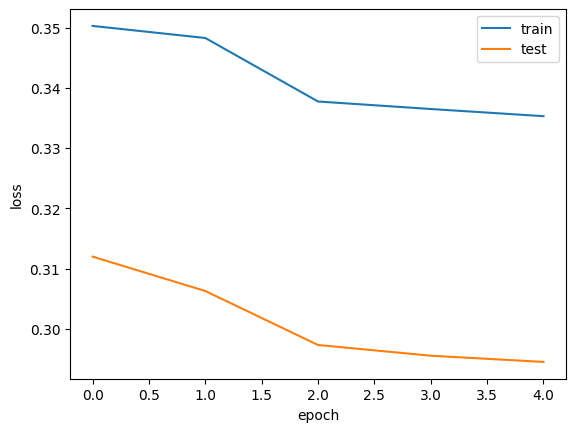

TRAIN: 150549 TEST: 74344
dataset built
Loss in trainset: 0.3384
Loss in testset: 0.3349


pre-train:   0%|          | 0/59508 [00:00<?, ?it/s]

w: [1.0216, 2.7775, 5.0, 0.5, 0.5, 0.2, 1.4, 0.2, 0.8, 2.0, 0.2, 0.2, 1.0]


train:   0%|          | 0/392139 [00:00<?, ?it/s]

Loss in trainset: 0.3339
Loss in testset: 0.3322
iteration: 38912
w: [1.0776, 2.855, 5.2742, 1.9709, 1.3092, 0.05, 1.5649, 0.257, 1.0871, 1.497, 0.7528, 0.4138, 1.0524]
iteration: 77824
w: [1.0776, 2.8551, 4.8803, 1.7001, 1.2612, 0.05, 1.5473, 0.3783, 1.144, 1.5847, 0.6873, 0.3093, 1.3081]
iteration: 116736
w: [1.0776, 2.8551, 4.6985, 1.8618, 1.2098, 0.05, 1.4645, 0.1806, 1.057, 1.5712, 0.7269, 0.4312, 1.4697]
Loss in trainset: 0.3237
Loss in testset: 0.3200
iteration: 155289
w: [1.0776, 2.8551, 4.6476, 1.8702, 1.0789, 0.05, 1.4264, 0.2843, 1.0105, 1.606, 0.6851, 0.4176, 1.5551]
iteration: 194201
w: [1.0776, 2.8551, 4.5612, 1.9405, 1.0375, 0.05, 1.4145, 0.2614, 0.9809, 1.6004, 0.6838, 0.369, 1.5239]
iteration: 233113
w: [1.0776, 2.8551, 4.4577, 1.8374, 1.1174, 0.05, 1.4741, 0.221, 1.0497, 1.6069, 0.6753, 0.4129, 1.4812]
Loss in trainset: 0.3207
Loss in testset: 0.3172
iteration: 271666
w: [1.0776, 2.8551, 4.4858, 1.8876, 1.0937, 0.0538, 1.4459, 0.3141, 1.0249, 1.6453, 0.6252, 0.4011, 1

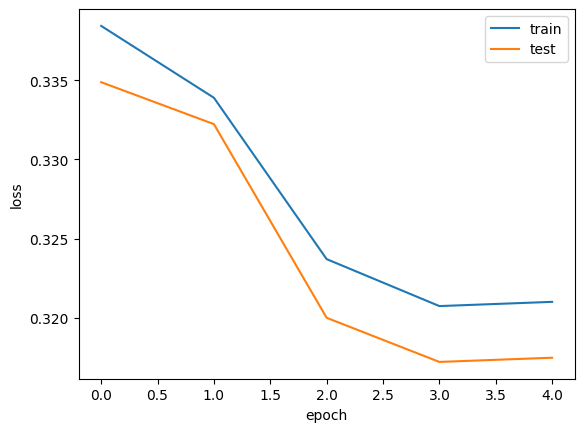

TRAIN: 150766 TEST: 74127
dataset built
Loss in trainset: 0.3233
Loss in testset: 0.3657


pre-train:   0%|          | 0/62199 [00:00<?, ?it/s]

w: [2.2441, 2.455, 5.0, 0.5, 0.5, 0.2, 1.4, 0.2, 0.8, 2.0, 0.2, 0.2, 1.0]


train:   0%|          | 0/390099 [00:00<?, ?it/s]

Loss in trainset: 0.3191
Loss in testset: 0.3700
iteration: 38912
w: [2.3014, 2.523, 5.0758, 1.7466, 1.4821, 0.05, 1.5912, 0.1738, 1.0923, 1.6266, 0.6646, 0.3608, 1.0959]
iteration: 77824
w: [2.3014, 2.523, 4.8658, 1.8174, 1.2462, 0.05, 1.4829, 0.4341, 1.0355, 1.6919, 0.6232, 0.3382, 1.6]
iteration: 116736
w: [2.3014, 2.523, 4.8335, 2.2689, 1.0156, 0.05, 1.5214, 0.3248, 1.0862, 1.6457, 0.7101, 0.4251, 1.926]
Loss in trainset: 0.3096
Loss in testset: 0.3615
iteration: 155633
w: [2.3014, 2.523, 4.5986, 2.0187, 1.0739, 0.05, 1.4506, 0.2719, 0.9928, 1.5772, 0.7867, 0.3435, 1.9295]
iteration: 194545
w: [2.3014, 2.523, 4.5473, 1.9815, 1.0115, 0.0673, 1.477, 0.2738, 1.019, 1.5332, 0.8241, 0.3648, 1.9904]
iteration: 233457
w: [2.3014, 2.523, 4.5321, 2.0913, 0.9877, 0.0532, 1.5471, 0.3401, 1.0841, 1.6179, 0.7503, 0.4705, 1.9971]
Loss in trainset: 0.3073
Loss in testset: 0.3594
iteration: 272354
w: [2.3014, 2.523, 4.5032, 1.9839, 1.0002, 0.05, 1.5118, 0.3222, 1.0397, 1.6226, 0.7394, 0.4472, 2.0]

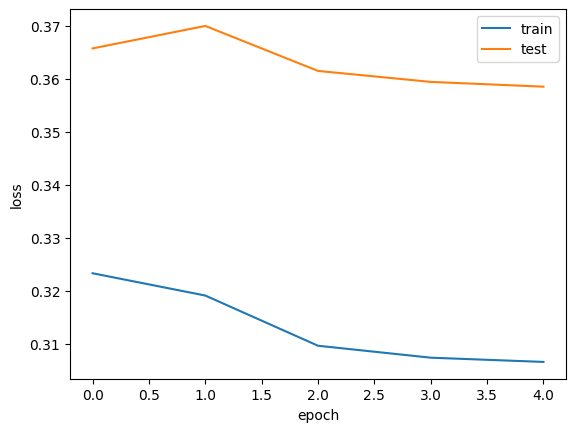


Training finished!


In [5]:
dataset = pd.read_csv("./revlog_history.tsv", sep='\t', index_col=None, dtype={'r_history': str ,'t_history': str} )
dataset = dataset[(dataset['i'] > 1) & (dataset['delta_t'] > 0) & (dataset['t_history'].str.count(',0') == 0)]
dataset['tensor'] = dataset.progress_apply(lambda x: lineToTensor(list(zip([x['t_history']], [x['r_history']]))[0]), axis=1)
dataset['y'] = dataset['r'].map({1: 0, 2: 1, 3: 1, 4: 1})
dataset['group'] = dataset['r_history'] + dataset['t_history']
print("Tensorized!")

from sklearn.model_selection import StratifiedGroupKFold

w = []

sgkf = StratifiedGroupKFold(n_splits=3)
for train_index, test_index in sgkf.split(dataset, dataset['i'], dataset['group']):
    print("TRAIN:", len(train_index), "TEST:",  len(test_index))
    train_set = dataset.iloc[train_index].copy()
    test_set = dataset.iloc[test_index].copy()
    optimizer = Optimizer(train_set, test_set, n_epoch=3, lr=4e-2, batch_size=512)
    w.append(optimizer.train())
    optimizer.plot()

print("\nTraining finished!")

### 2.3 Result

Copy the optimal parameters for FSRS for you in the output of next code cell after running.

In [6]:
w = np.array(w)
avg_w = np.round(np.mean(w, axis=0), 4)
print(avg_w.tolist())

[1.4721, 2.5126, 4.445, 1.9621, 1.0688, 0.05, 1.5143, 0.3003, 1.032, 1.5804, 0.7133, 0.4071, 1.7639]


### 2.4 Preview

You can see the memory states and intervals generated by FSRS as if you press the good in each review at the due date scheduled by FSRS.

In [7]:
requestRetention = 0.9  # recommended setting: 0.8 ~ 0.9


class Collection:
    def __init__(self, w):
        self.model = FSRS(w)
        self.model.eval()

    def predict(self, t_history, r_history):
        with torch.no_grad():
            line_tensor = lineToTensor(list(zip([t_history], [r_history]))[0]).unsqueeze(1)
            output_t = self.model(line_tensor)
            return output_t[-1][0]
        
    def batch_predict(self, dataset):
        fast_dataset = RevlogDataset(dataset)
        with torch.no_grad():
            outputs, _ = self.model(fast_dataset.x_train.transpose(0, 1))
            stabilities, difficulties = outputs[fast_dataset.seq_len-1, torch.arange(len(fast_dataset))].transpose(0, 1)
            return stabilities.tolist(), difficulties.tolist()

my_collection = Collection(avg_w)
print("1:again, 2:hard, 3:good, 4:easy\n")
for first_rating in (1,2,3,4):
    print(f'first rating: {first_rating}')
    t_history = "0"
    d_history = "0"
    r_history = f"{first_rating}"  # the first rating of the new card
    # print("stability, difficulty, lapses")
    for i in range(10):
        states = my_collection.predict(t_history, r_history)
        # print('{0:9.2f} {1:11.2f} {2:7.0f}'.format(
            # *list(map(lambda x: round(float(x), 4), states))))
        next_t = max(round(float(np.log(requestRetention)/np.log(0.9) * states[0])), 1)
        difficulty = round(float(states[1]), 1)
        t_history += f',{int(next_t)}'
        d_history += f',{difficulty}'
        r_history += f",3"
    print(f"rating history: {r_history}")
    print("interval history: " + ",".join([f"{ivl}d" if ivl < 30 else f"{ivl / 30:.1f}m" if ivl < 365 else f"{ivl / 365:.1f}y" for ivl in map(int, t_history.split(','))]))
    print(f"difficulty history: {d_history}")
    print('')

1:again, 2:hard, 3:good, 4:easy

first rating: 1
rating history: 1,3,3,3,3,3,3,3,3,3,3
interval history: 0d,1d,3d,6d,12d,21d,1.2m,1.9m,3.0m,4.5m,6.6m
difficulty history: 0,8.4,8.2,8.0,7.8,7.6,7.5,7.3,7.2,7.0,6.9

first rating: 2
rating history: 2,3,3,3,3,3,3,3,3,3,3
interval history: 0d,4d,10d,22d,1.4m,2.6m,4.3m,6.8m,10.4m,1.2y,1.8y
difficulty history: 0,6.4,6.3,6.2,6.1,6.0,6.0,5.9,5.8,5.7,5.7

first rating: 3
rating history: 3,3,3,3,3,3,3,3,3,3,3
interval history: 0d,6d,18d,1.4m,2.9m,5.3m,9.1m,1.2y,1.8y,2.7y,3.7y
difficulty history: 0,4.4,4.4,4.4,4.4,4.4,4.4,4.4,4.4,4.4,4.4

first rating: 4
rating history: 4,3,3,3,3,3,3,3,3,3,3
interval history: 0d,9d,28d,2.4m,5.0m,9.5m,1.4y,2.2y,3.3y,4.9y,6.9y
difficulty history: 0,2.5,2.6,2.7,2.8,2.8,2.9,3.0,3.1,3.1,3.2



You can change the `test_rating_sequence` to see the scheduling intervals in different ratings.

In [8]:
test_rating_sequence = "3,3,3,3,3,1,1,3,3,3,3,3"
requestRetention = 0.9  # recommended setting: 0.8 ~ 0.9
easyBonus = 1.3
hardInterval = 1.2

t_history = "0"
d_history = "0"
for i in range(len(test_rating_sequence.split(','))):
    rating = test_rating_sequence[2*i]
    last_t = int(t_history.split(',')[-1])
    r_history = test_rating_sequence[:2*i+1]
    states = my_collection.predict(t_history, r_history)
    print(states)
    next_t = max(1,round(float(np.log(requestRetention)/np.log(0.9) * states[0])))
    if rating == '4':
        next_t = round(next_t * easyBonus)
    elif rating == '2':
        next_t = round(last_t * hardInterval)
    t_history += f',{int(next_t)}'
    difficulty = round(float(states[1]), 1)
    d_history += f',{difficulty}'
print(f"rating history: {test_rating_sequence}")
print(f"interval history: {t_history}")
print(f"difficulty history: {d_history}")

tensor([6.4973, 4.4450])
tensor([17.5803,  4.4450])
tensor([42.2337,  4.4450])
tensor([86.4493,  4.4450])
tensor([159.4623,   4.4450])
tensor([3.9190, 6.4757])
tensor([0.7226, 8.4049])
tensor([2.2430, 8.2069])
tensor([4.5555, 8.0188])
tensor([9.5069, 7.8401])
tensor([17.8740,  7.6704])
tensor([30.9386,  7.5091])
rating history: 3,3,3,3,3,1,1,3,3,3,3,3
interval history: 0,6,18,42,86,159,4,1,2,5,10,18,31
difficulty history: 0,4.4,4.4,4.4,4.4,4.4,6.5,8.4,8.2,8.0,7.8,7.7,7.5


### 2.5 Predict memory states and distribution of difficulty

Predict memory states for each review group and save them in [./prediction.tsv](./prediction.tsv).

Meanwhile, it will count the distribution of difficulty.

In [9]:
stabilities, difficulties = my_collection.batch_predict(dataset)
stabilities = map(lambda x: round(x, 2), stabilities)
difficulties = map(lambda x: round(x, 2), difficulties)
dataset['stability'] = list(stabilities)
dataset['difficulty'] = list(difficulties)
prediction = dataset.groupby(by=['t_history', 'r_history']).agg({"stability": "mean", "difficulty": "mean", "id": "count"})
prediction.reset_index(inplace=True)
prediction.sort_values(by=['r_history'], inplace=True)
prediction.rename(columns={"id": "count"}, inplace=True)
prediction.to_csv("./prediction.tsv", sep='\t', index=None)
print("prediction.tsv saved.")
prediction['difficulty'] = prediction['difficulty'].map(lambda x: int(round(x)))
difficulty_distribution = prediction.groupby(by=['difficulty'])['count'].sum() / prediction['count'].sum()
print(difficulty_distribution)
difficulty_distribution_padding = np.zeros(10)
for i in range(10):
    if i+1 in difficulty_distribution.index:
        difficulty_distribution_padding[i] = difficulty_distribution.loc[i+1]

prediction.tsv saved.
difficulty
1     0.012206
2     0.089945
3     0.101506
4     0.161041
5     0.057770
6     0.057307
7     0.047098
8     0.130418
9     0.156292
10    0.186418
Name: count, dtype: float64


## 3 Optimize retention to minimize the time of reviews

Calculate the optimal retention to minimize the time for long-term memory consolidation. It is an experimental feature. You can use the simulator to get more accurate results:

https://github.com/open-spaced-repetition/fsrs4anki/blob/main/fsrs4anki_simulator.ipynb

average time for failed cards: 25.0s
average time for recalled cards: 8.0s
terminal stability:  876.71


find optimal retention:   0%|          | 0/15 [00:00<?, ?it/s]

expected_time.csv saved.

-----suggested retention (experimental): 0.85-----


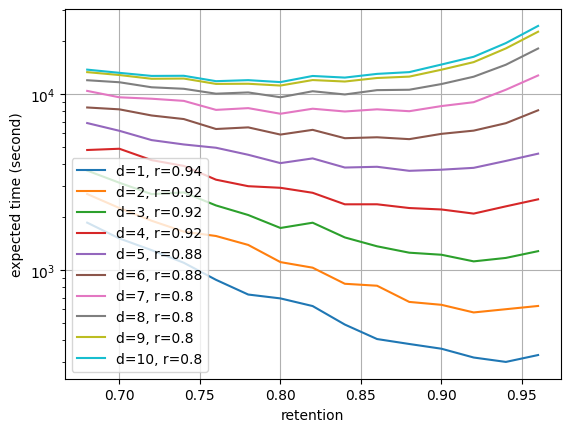

In [10]:
base = 1.01
minimum_stability = 0.1
index_offset = -(np.log(minimum_stability) / np.log(base)).round().astype(int)
d_range = 10
d_offset = 1
r_time = 8
f_time = 25
max_time = 1e10

type_block = dict()
type_count = dict()
type_time = dict()
last_t = type_sequence[0]
type_block[last_t] = 1
type_count[last_t] = 1
type_time[last_t] = time_sequence[0]
for i,t in enumerate(type_sequence[1:]):
    type_count[t] = type_count.setdefault(t, 0) + 1
    type_time[t] = type_time.setdefault(t, 0) + time_sequence[i]
    if t != last_t:
        type_block[t] = type_block.setdefault(t, 0) + 1
    last_t = t

r_time = round(type_time[1]/type_count[1]/1000, 1)

if 2 in type_count and 2 in type_block:
    f_time = round(type_time[2]/type_block[2]/1000 + r_time, 1)

print(f"average time for failed cards: {f_time}s")
print(f"average time for recalled cards: {r_time}s")

def stability2index(stability):
    return (np.log(stability) / np.log(base)).round().astype(int) + index_offset

def init_stability(d):
    return max(((d - avg_w[2]) / -avg_w[3] + 2) * avg_w[1] + avg_w[0], np.power(base, -index_offset))

def cal_next_recall_stability(s, r, d, response):
    if response == 1:
        return s * (1 + np.exp(avg_w[6]) * (11 - d) * np.power(s, -avg_w[7]) * (np.exp((1 - r) * avg_w[8]) - 1))
    else:
        return avg_w[9] * np.power(d, -avg_w[10]) * np.power(s, avg_w[11]) * np.exp((1 - r) * avg_w[12])

terminal_stability = minimum_stability
for _ in range(128):
    terminal_stability = cal_next_recall_stability(terminal_stability, 0.96, 10, 1)
index_len = stability2index(terminal_stability)
stability_list = np.array([np.power(base, i - index_offset) for i in range(index_len)])
print(f"terminal stability: {stability_list.max(): .2f}")
df = pd.DataFrame(columns=["retention", "difficulty", "time"])

for percentage in notebook.tqdm(range(96, 66, -2), desc="find optimal retention"):
    recall = percentage / 100
    time_list = np.zeros((d_range, index_len))
    time_list[:,:-1] = max_time
    for d in range(d_range, 0, -1):
        s0 = init_stability(d)
        s0_index = stability2index(s0)
        diff = max_time
        iteration = 0
        while diff > 1 and iteration < 2e5:
            iteration += 1
            total_time = time_list[d - 1].sum()
            s_indices = np.arange(index_len - 2, -1, -1)
            stabilities = stability_list[s_indices]
            intervals = np.maximum(1, np.round(stabilities * np.log(recall) / np.log(0.9)))
            p_recalls = np.power(0.9, intervals / stabilities)
            recall_s = cal_next_recall_stability(stabilities, p_recalls, d, 1)
            forget_d = np.minimum(d + d_offset, 10)
            forget_s = cal_next_recall_stability(stabilities, p_recalls, forget_d, 0)
            recall_s_indices = np.minimum(stability2index(recall_s), index_len - 1)
            forget_s_indices = np.clip(stability2index(forget_s), 0, index_len - 1)
            recall_times = time_list[d - 1][recall_s_indices] + r_time
            forget_times = time_list[forget_d - 1][forget_s_indices] + f_time
            exp_times = p_recalls * recall_times + (1.0 - p_recalls) * forget_times
            mask = exp_times <= time_list[d - 1][s_indices]
            time_list[d - 1][s_indices[mask]] = exp_times[mask]
            diff = total_time - time_list[d - 1].sum()
            s0_time = time_list[d - 1][s0_index]
            if iteration % 1e5 == 0:
                print(f"iteration: {iteration}, diff: {diff}, s0_time: {s0_time}")
        df.loc[0 if pd.isnull(df.index.max()) else df.index.max() + 1] = [recall, d, s0_time]

df.sort_values(by=["difficulty", "retention"], inplace=True)
df.to_csv("./expected_time.csv", index=False)
print("expected_time.csv saved.")

optimal_retention_list = np.zeros(10)
for d in range(1, d_range+1):
    retention = df[df["difficulty"] == d]["retention"]
    time = df[df["difficulty"] == d]["time"]
    optimal_retention = retention.iat[time.argmin()]
    optimal_retention_list[d-1] = optimal_retention
    plt.plot(retention, time, label=f"d={d}, r={optimal_retention}")
print(f"\n-----suggested retention (experimental): {np.inner(difficulty_distribution_padding, optimal_retention_list):.2f}-----")
plt.ylabel("expected time (second)")
plt.xlabel("retention")
plt.legend()
plt.grid()
plt.semilogy()
plt.show()

## 4 Evaluate the model

### 4.1 Loss

Evaluate the model with the log loss. It will compare the log loss between initial model and trained model.

And it will predict the stability, difficulty and retrievability for each revlog in [./evaluation.tsv](./evaluation.tsv).

In [11]:
my_collection = Collection(init_w)
stabilities, difficulties = my_collection.batch_predict(dataset)
dataset['stability'] = stabilities
dataset['difficulty'] = difficulties
dataset['p'] = np.exp(np.log(0.9) * dataset['delta_t'] / dataset['stability'])
dataset['log_loss'] = dataset.apply(lambda row: - np.log(row['p']) if row['y'] == 1 else - np.log(1 - row['p']), axis=1)
print(f"Loss before training: {dataset['log_loss'].mean():.4f}")

my_collection = Collection(avg_w)
stabilities, difficulties = my_collection.batch_predict(dataset)
dataset['stability'] = stabilities
dataset['difficulty'] = difficulties
dataset['p'] = np.exp(np.log(0.9) * dataset['delta_t'] / dataset['stability'])
dataset['log_loss'] = dataset.apply(lambda row: - np.log(row['p']) if row['y'] == 1 else - np.log(1 - row['p']), axis=1)
print(f"Loss after training: {dataset['log_loss'].mean():.4f}")

tmp = dataset.copy()
tmp['stability'] = tmp['stability'].map(lambda x: round(x, 2))
tmp['difficulty'] = tmp['difficulty'].map(lambda x: round(x, 2))
tmp['p'] = tmp['p'].map(lambda x: round(x, 2))
tmp['log_loss'] = tmp['log_loss'].map(lambda x: round(x, 2))
tmp.rename(columns={"r": "grade", "p": "retrievability"}, inplace=True)
tmp[['id', 'cid', 'review_date', 'r_history', 't_history', 'delta_t', 'grade', 'stability', 'difficulty', 'retrievability', 'log_loss']].to_csv("./evaluation.tsv", sep='\t', index=False)
del tmp

Loss before training: 0.3373
Loss after training: 0.3212


### 4.2 Calibration graph

1. FSRS predicts the stability and retention for each review.
2. Reviews are grouped into 40 bins according to their predicted retention.
3. Count the true retention of each bin.
4. Plot (predicted retention, true retention) in the line graph.
5. Plot (predicted retention, size of bin) in the bar graph.
6. Combine these graphs to create the calibration graph.

Ideally, the blue line should be aligned with the orange one. If the blue line is higher than the orange line, the FSRS underestimates the retention. When the size of reviews within a bin is small, actual retention may deviate largely, which is normal.

R-squared (aka the coefficient of determination), is the proportion of the variation in the dependent variable that is predictable from the independent variable(s). The higher the R-squared, the better the model fits your data. For details, please see https://en.wikipedia.org/wiki/Coefficient_of_determination

RMSE (root mean squared error) is the square root of the average of squared differences between prediction and actual observation. The lower the RMSE, the better the model fits your data. For details, please see https://en.wikipedia.org/wiki/Root-mean-square_deviation

R-squared: 0.7443
RMSE: 0.0273
[0.27570358 0.69590327]
Last rating: 1
R-squared: -1.0421
RMSE: 0.0858
[0.54874068 0.37127301]
Last rating: 2
R-squared: -0.0735
RMSE: 0.0482
[-0.02998051  0.98241886]
Last rating: 3
R-squared: 0.9282
RMSE: 0.0167
[0.07694361 0.92374331]
Last rating: 4
R-squared: 0.2152
RMSE: 0.0337
[0.34890598 0.64421847]


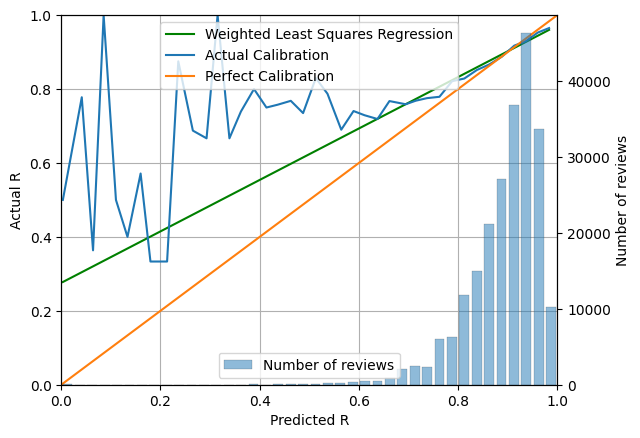

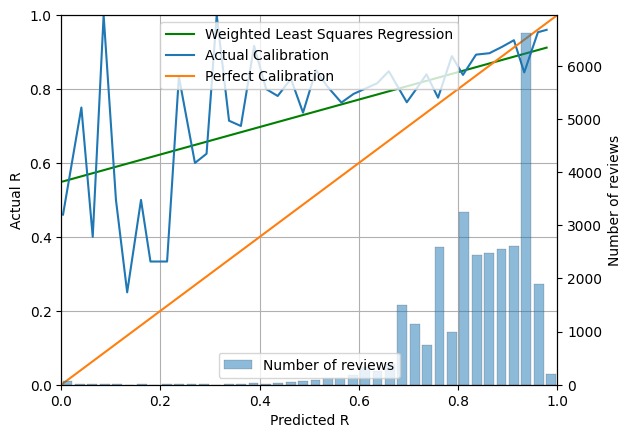

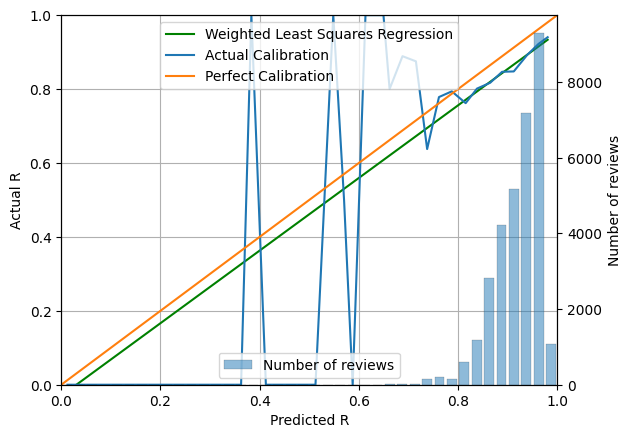

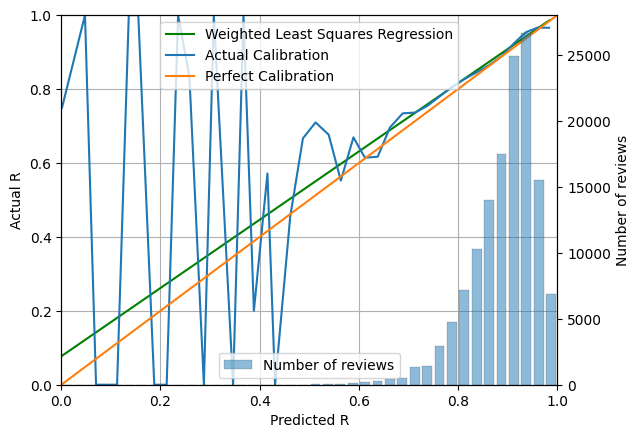

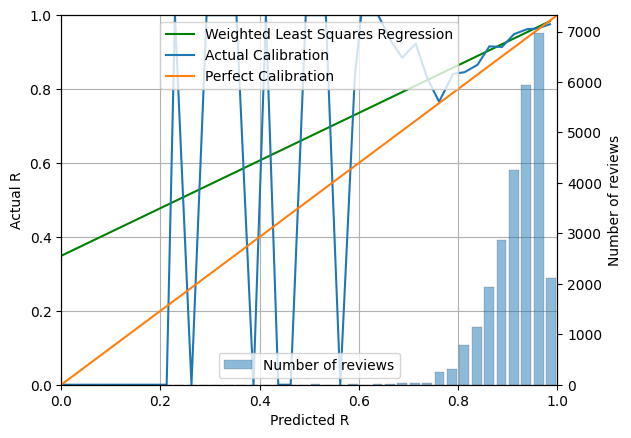

In [12]:
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm


# code from https://github.com/papousek/duolingo-halflife-regression/blob/master/evaluation.py
def load_brier(predictions, real, bins=20):
    counts = np.zeros(bins)
    correct = np.zeros(bins)
    prediction = np.zeros(bins)
    for p, r in zip(predictions, real):
        bin = min(int(p * bins), bins - 1)
        counts[bin] += 1
        correct[bin] += r
        prediction[bin] += p
    np.seterr(invalid='ignore')
    prediction_means = prediction / counts
    prediction_means[np.isnan(prediction_means)] = ((np.arange(bins) + 0.5) / bins)[np.isnan(prediction_means)]
    correct_means = correct / counts
    correct_means[np.isnan(correct_means)] = 0
    size = len(predictions)
    answer_mean = sum(correct) / size
    return {
        "reliability": sum(counts * (correct_means - prediction_means) ** 2) / size,
        "resolution": sum(counts * (correct_means - answer_mean) ** 2) / size,
        "uncertainty": answer_mean * (1 - answer_mean),
        "detail": {
            "bin_count": bins,
            "bin_counts": list(counts),
            "bin_prediction_means": list(prediction_means),
            "bin_correct_means": list(correct_means),
        }
    }


def plot_brier(predictions, real, bins=20):
    brier = load_brier(predictions, real, bins=bins)
    bin_prediction_means = brier['detail']['bin_prediction_means']
    bin_correct_means = brier['detail']['bin_correct_means']
    bin_counts = brier['detail']['bin_counts']
    r2 = r2_score(bin_correct_means, bin_prediction_means, sample_weight=bin_counts)
    rmse = mean_squared_error(bin_correct_means, bin_prediction_means, sample_weight=bin_counts, squared=False)
    print(f"R-squared: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    plt.figure()
    ax = plt.gca()
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.grid(True)
    fit_wls = sm.WLS(bin_correct_means, sm.add_constant(bin_prediction_means), weights=bin_counts).fit()
    print(fit_wls.params)
    y_regression = [fit_wls.params[0] + fit_wls.params[1]*x for x in bin_prediction_means]
    plt.plot(bin_prediction_means, y_regression, label='Weighted Least Squares Regression', color="green")
    plt.plot(bin_prediction_means, bin_correct_means, label='Actual Calibration', color="#1f77b4")
    plt.plot((0, 1), (0, 1), label='Perfect Calibration', color="#ff7f0e")
    bin_count = brier['detail']['bin_count']
    counts = np.array(bin_counts)
    bins = (np.arange(bin_count) + 0.5) / bin_count
    plt.legend(loc='upper center')
    plt.xlabel('Predicted R')
    plt.ylabel('Actual R')
    plt.twinx()
    plt.ylabel('Number of reviews')
    plt.bar(bins, counts, width=(0.8 / bin_count), ec='k', lw=.2, alpha=0.5, label='Number of reviews')
    plt.legend(loc='lower center')

plot_brier(dataset['p'], dataset['y'], bins=40)
for last_rating in ("1","2","3","4"):
    print(f"Last rating: {last_rating}")
    plot_brier(dataset[dataset['r_history'].str.endswith(last_rating)]['p'], dataset[dataset['r_history'].str.endswith(last_rating)]['y'], bins=40)
plt.show()

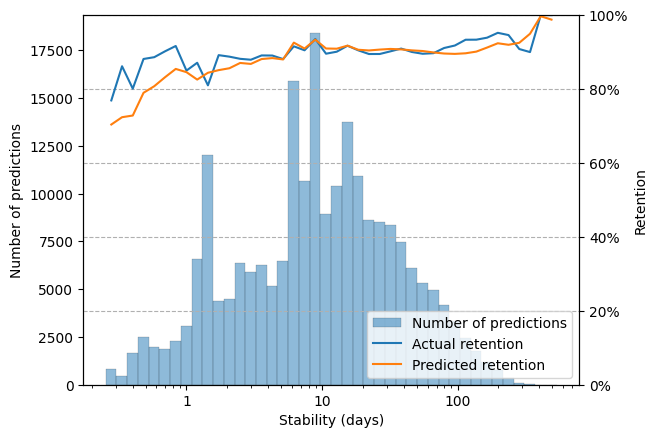

In [13]:
import matplotlib.ticker as ticker

def to_percent(temp, position):
    return '%1.0f' % (100 * temp) + '%'

fig = plt.figure(1)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
lns = []

stability_calibration = pd.DataFrame(columns=['stability', 'predicted_retention', 'actual_retention'])
stability_calibration = dataset[['stability', 'p', 'y']].copy()
stability_calibration['bin'] = stability_calibration['stability'].map(lambda x: math.pow(1.2, math.floor(math.log(x, 1.2))))
stability_group = stability_calibration.groupby('bin').count()

lns1 = ax1.bar(x=stability_group.index, height=stability_group['y'], width=stability_group.index / 5.5,
                ec='k', lw=.2, label='Number of predictions', alpha=0.5)
ax1.set_ylabel("Number of predictions")
ax1.set_xlabel("Stability (days)")
ax1.semilogx()
lns.append(lns1)

stability_group = stability_calibration.groupby(by='bin').agg('mean')
lns2 = ax2.plot(stability_group['y'], label='Actual retention')
lns3 = ax2.plot(stability_group['p'], label='Predicted retention')
ax2.set_ylabel("Retention")
ax2.set_ylim(0, 1)
lns.append(lns2[0])
lns.append(lns3[0])

labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc='lower right')
plt.grid(linestyle='--')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(to_percent))
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
plt.show()

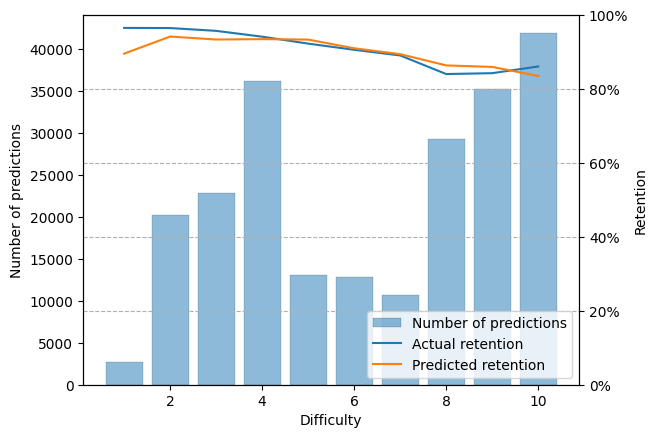

In [14]:
fig = plt.figure(1)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
lns = []

difficulty_calibration = pd.DataFrame(columns=['difficulty', 'predicted_retention', 'actual_retention'])
difficulty_calibration = dataset[['difficulty', 'p', 'y']].copy()
difficulty_calibration['bin'] = difficulty_calibration['difficulty'].map(round)
difficulty_group = difficulty_calibration.groupby('bin').count()

lns1 = ax1.bar(x=difficulty_group.index, height=difficulty_group['y'],
                ec='k', lw=.2, label='Number of predictions', alpha=0.5)
ax1.set_ylabel("Number of predictions")
ax1.set_xlabel("Difficulty")
lns.append(lns1)

difficulty_group = difficulty_calibration.groupby(by='bin').agg('mean')
lns2 = ax2.plot(difficulty_group['y'], label='Actual retention')
lns3 = ax2.plot(difficulty_group['p'], label='Predicted retention')
ax2.set_ylabel("Retention")
ax2.set_ylim(0, 1)
lns.append(lns2[0])
lns.append(lns3[0])

labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc='lower right')
plt.grid(linestyle='--')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(to_percent))
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
plt.show()

In [15]:
B_W_Metric_raw = dataset[['difficulty', 'stability', 'p', 'y']].copy()
B_W_Metric_raw['s_bin'] = B_W_Metric_raw['stability'].map(lambda x: round(math.pow(1.4, math.floor(math.log(x, 1.4))), 2))
B_W_Metric_raw['d_bin'] = B_W_Metric_raw['difficulty'].map(lambda x: int(round(x)))
B_W_Metric = B_W_Metric_raw.groupby(by=['s_bin', 'd_bin']).agg('mean').reset_index()
B_W_Metric_count = B_W_Metric_raw.groupby(by=['s_bin', 'd_bin']).agg('count').reset_index()
B_W_Metric['B-W'] = B_W_Metric['p'] - B_W_Metric['y']
n = len(dataset)
bins = len(B_W_Metric)
B_W_Metric_pivot = B_W_Metric[B_W_Metric_count['p'] > max(50, n / (3 * bins))].pivot(index="s_bin", columns='d_bin', values='B-W')
B_W_Metric_pivot.apply(pd.to_numeric).style.background_gradient(cmap='seismic', axis=None, vmin=-0.2, vmax=0.2).format("{:.2%}", na_rep='')

d_bin,1,2,3,4,5,6,7,8,9,10
s_bin,,,,,,,,,,
0.260000,,,,,,,,,,-8.60%
0.360000,,,,,,,,,,-8.20%
0.510000,,,,,,,,,,-8.38%
0.710000,,,,,,,,,,-6.33%
1.000000,,,,,,,,,,-2.84%
1.400000,,,,,-1.09%,-1.41%,,7.16%,-1.90%,-5.52%
1.960000,,,,,,-2.93%,,0.28%,-0.31%,-4.45%
2.740000,,,,,,-3.43%,-0.95%,-4.22%,-1.67%,-1.50%
3.840000,,,,,-3.30%,-1.23%,,-1.57%,-0.48%,1.56%


In [16]:
B_W_Metric_raw['r_bin'] = B_W_Metric_raw['p'].map(lambda x: round(x * 4, 1) / 4)
R_Matrix = B_W_Metric_raw.groupby(by=['s_bin', 'd_bin', 'r_bin']).agg({'y': ['mean', 'count']}).reset_index()
R_Matrix.columns = ['S_rounded', 'D_rounded', 'R_t_rounded', 'R_measured', 'count']
R_Matrix = R_Matrix[R_Matrix['count'] > 300]
print("DiffMax:", max(abs(R_Matrix['R_t_rounded'] - R_Matrix['R_measured'])))
R_Matrix

DiffMax: 0.1523328046523923


,S_rounded,D_rounded,R_t_rounded,R_measured,count
12,0.26,10,0.725,0.780379,897
47,0.36,10,0.775,0.790000,1100
48,0.36,10,0.800,0.874435,1107
100,0.51,10,0.825,0.889391,1329
101,0.51,10,0.850,0.894059,1397
...,...,...,...,...,...
1629,56.69,5,0.950,0.894191,482
1727,79.37,2,0.900,0.960219,729
1739,79.37,3,0.900,0.930314,574
1751,79.37,4,0.875,0.937349,415


### 4.3 Comparision with Anki bulit-in algorithm

In [17]:
def anki(history):
    ivl = 0
    start_ease = 2.5
    hard_interval = 1.2
    ease_bonus = 1.3
    graduating_interval = 1
    easy_interval = 4
    new_interval = 0
    minimum_interval = 1
    interval_modifier = 1
    for i, (delta_t, rating) in enumerate(history):
        delta_t = delta_t.item()
        rating = rating.item()
        if i == 0:
            ease = start_ease
            if rating == 4:
                ivl = easy_interval
            else:
                ivl = graduating_interval
        else:
            delay = delta_t - ivl
            if delay >= 0:
                if rating == 1:
                    ivl = max(ivl * new_interval, minimum_interval)
                    ease -= 0.2
                elif rating == 2:
                    ivl = ivl * hard_interval
                    ease -= 0.15
                elif rating == 3:
                    ivl = (ivl + delay // 2) * ease
                else:
                    ivl = (ivl + delay) * ease * ease_bonus
                    ease += 0.15
            # early_review
            else:
                if rating == 1:
                    ivl = max(ivl * new_interval, minimum_interval)
                    ease -= 0.2
                elif rating == 2:
                    ivl = max(delta_t * hard_interval / 2, ivl * hard_interval)
                    ease -= 0.15
                elif rating == 3:
                    ivl = max(delta_t * ease, ivl)
                else:
                    ivl = max(delta_t * ease, ivl) * (0.5 * ease_bonus + 0.5)
                    ease += 0.15
            ivl = ivl * interval_modifier
        ease = max(1.3, ease)
        ivl = max(1, round(ivl+0.01))
    return ivl

def sm2(history):
    ivl = 0
    ef = 2.5
    reps = 0
    for delta_t, rating in history:
        delta_t = delta_t.item()
        rating = rating.item() + 1
        if rating > 2:
            if reps == 0:
                ivl = 1
                reps = 1
            elif reps == 1:
                ivl = 6
                reps = 2
            else:
                ivl = ivl * ef
                reps += 1
        else:
            ivl = 1
            reps = 0
        ef = max(1.3, ef + (0.1 - (5 - rating) * (0.08 + (5 - rating) * 0.02)))
        ivl = max(1, round(ivl+0.01))
    return ivl

dataset['sm2_interval'] = dataset['tensor'].map(sm2)
dataset['sm2_p'] = np.exp(np.log(0.9) * dataset['delta_t'] / dataset['sm2_interval'])
cross_comparison = dataset[['sm2_p', 'p', 'y']].copy()

R_Metric:  0.03340962095346084
R-squared: -21.5980
RMSE: 0.1408
[0.76478601 0.15818509]


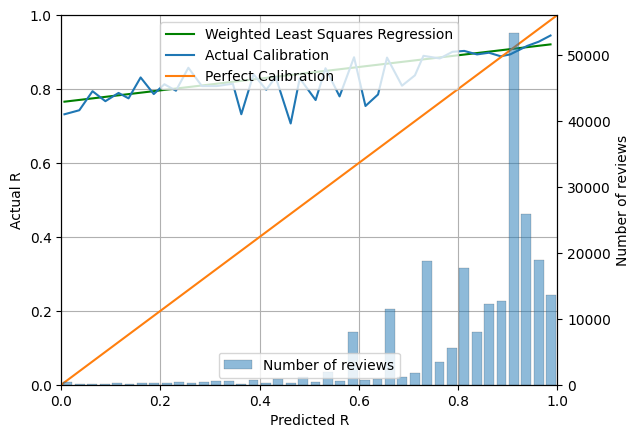

In [18]:
R_Metric = mean_squared_error(cross_comparison['y'], cross_comparison['sm2_p'], squared=False) - mean_squared_error(cross_comparison['y'], cross_comparison['p'], squared=False)
print("R_Metric: ", R_Metric)
plot_brier(dataset['sm2_p'], dataset['y'], bins=40)
plt.show()

Universal Metric of FSRS: 0.0183
Universal Metric of SM2: 0.0717


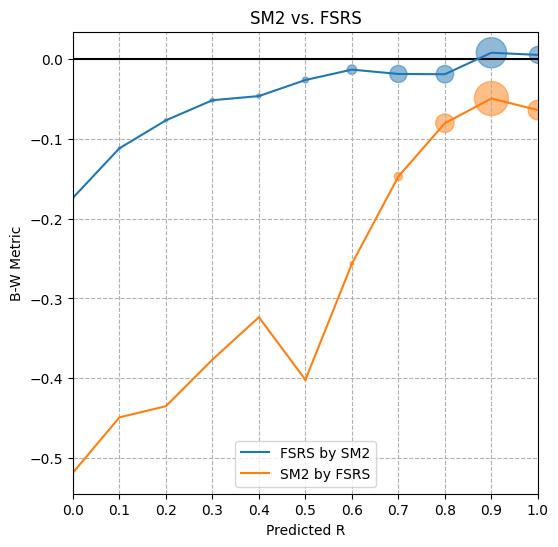

In [19]:
plt.figure(figsize=(6, 6))

cross_comparison['SM2_B-W'] = cross_comparison['sm2_p'] - cross_comparison['y']
cross_comparison['SM2_bin'] = cross_comparison['sm2_p'].map(lambda x: round(x, 1))
cross_comparison['FSRS_B-W'] = cross_comparison['p'] - cross_comparison['y']
cross_comparison['FSRS_bin'] = cross_comparison['p'].map(lambda x: round(x, 1))

plt.axhline(y = 0.0, color = 'black', linestyle = '-')

cross_comparison_group = cross_comparison.groupby(by='SM2_bin').agg({'y': ['mean'], 'FSRS_B-W': ['mean'], 'p': ['mean', 'count']})
print(f"Universal Metric of FSRS: {mean_squared_error(cross_comparison_group['y', 'mean'], cross_comparison_group['p', 'mean'], sample_weight=cross_comparison_group['p', 'count'], squared=False):.4f}")
cross_comparison_group['p', 'percent'] = cross_comparison_group['p', 'count'] / cross_comparison_group['p', 'count'].sum()
plt.scatter(cross_comparison_group.index, cross_comparison_group['FSRS_B-W', 'mean'], s=cross_comparison_group['p', 'percent'] * 1024, alpha=0.5)
plt.plot(cross_comparison_group['FSRS_B-W', 'mean'], label='FSRS by SM2')

cross_comparison_group = cross_comparison.groupby(by='FSRS_bin').agg({'y': ['mean'], 'SM2_B-W': ['mean'], 'sm2_p': ['mean', 'count']})
print(f"Universal Metric of SM2: {mean_squared_error(cross_comparison_group['y', 'mean'], cross_comparison_group['sm2_p', 'mean'], sample_weight=cross_comparison_group['sm2_p', 'count'], squared=False):.4f}")
cross_comparison_group['sm2_p', 'percent'] = cross_comparison_group['sm2_p', 'count'] / cross_comparison_group['sm2_p', 'count'].sum()
plt.scatter(cross_comparison_group.index, cross_comparison_group['SM2_B-W', 'mean'], s=cross_comparison_group['sm2_p', 'percent'] * 1024, alpha=0.5)
plt.plot(cross_comparison_group['SM2_B-W', 'mean'], label='SM2 by FSRS')

plt.legend(loc='lower center')
plt.grid(linestyle='--')
plt.title("SM2 vs. FSRS")
plt.xlabel('Predicted R')
plt.ylabel('B-W Metric')
plt.xlim(0, 1)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.show()